##### Задача: по замерам акселерометра и гироскопа, произведенным с помощью телефона, находящегося на поясе, научиться отделять различные типы активностей друг от друга.

In [1]:
#!pip install mlxtend

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots 

from yellowbrick.cluster import SilhouetteVisualizer

from mlxtend.plotting import plot_decision_regions


#### 1. Загрузите данные из источника по ссылке. 

In [3]:
try:
    data = np.loadtxt(
        "/home/olgatorres/PycharmProjects/ArchitectorAI/UCI HAR Dataset/X_train.txt"
    )
    with open(
        "/home/olgatorres/PycharmProjects/ArchitectorAI/UCI HAR Dataset/features.txt",
        "r",
    ) as f:
        lines = f.readlines()
    df = pd.DataFrame(data, columns=[line.rstrip() for line in lines])

except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

1.1. Ознакомьтесь с данными:
- выведите количество признаков;
- есть ли в данных пропуски;
- отличаются ли различные признаки по масштабу.

In [4]:
df.head()

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [5]:
df.columns

Index(['1 tBodyAcc-mean()-X', '2 tBodyAcc-mean()-Y', '3 tBodyAcc-mean()-Z',
       '4 tBodyAcc-std()-X', '5 tBodyAcc-std()-Y', '6 tBodyAcc-std()-Z',
       '7 tBodyAcc-mad()-X', '8 tBodyAcc-mad()-Y', '9 tBodyAcc-mad()-Z',
       '10 tBodyAcc-max()-X',
       ...
       '552 fBodyBodyGyroJerkMag-meanFreq()',
       '553 fBodyBodyGyroJerkMag-skewness()',
       '554 fBodyBodyGyroJerkMag-kurtosis()',
       '555 angle(tBodyAccMean,gravity)',
       '556 angle(tBodyAccJerkMean),gravityMean)',
       '557 angle(tBodyGyroMean,gravityMean)',
       '558 angle(tBodyGyroJerkMean,gravityMean)', '559 angle(X,gravityMean)',
       '560 angle(Y,gravityMean)', '561 angle(Z,gravityMean)'],
      dtype='object', length=561)

In [6]:
print(
    "Колонок с пропусками:", len([col for col in df.columns if df[col].isnull().any()])
)

Колонок с пропусками: 0


Мы видим, что в данных значения варьируются от -1 до 1.\
Но так как столбов много, проверим это.

In [7]:
print(
    "Колонок вне масштаба от-1 до 1:",
    len([col for col in df.columns if ((df[col] < -1) | (df[col] > 1)).any()]),
)

Колонок вне масштаба от-1 до 1: 0


#### 2. Понизьте размерность данных

2.1. Воспользуйтесь методом порога отклонения, чтобы избавиться от наблюдений, вариативность по которым низка.\
Удалите не более 10 % признаков.

In [8]:
df.shape[1] * 0.9

504.90000000000003

In [9]:
# 10% квантиль от дисперсии по всем признакам
threshold = round(np.quantile(df.var(), 0.1), 6)

In [10]:
var = VarianceThreshold(threshold=threshold)
df_reduced = var.fit_transform(df)
df_reduced.shape

(7352, 504)

2.2. Воспользуйтесь методом PCA.

2.2.1. Приведите признаки к одинаковому масштабу.

In [11]:
df_norm = StandardScaler().fit_transform(df_reduced)
# кол-во признаков
len_ = df_norm.shape[1]

In [12]:
# проверка сумм всех дисперсий
sum([df_norm[:, i].var() for i in range(df_norm.shape[1])])

504.0

2.2.2. Визуализируйте зависимость степени объяснения дисперсии исходных данных от количества выделяемых главных компонент.

In [13]:
pca = PCA(n_components=df_norm.shape[1])
pca = pca.fit(df_norm)

In [14]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

In [15]:
sorted(var_exp, reverse=True)[:10]

[0.5303877541275342,
 0.06458679036520243,
 0.02643243771434796,
 0.02573766505518103,
 0.01924599339586083,
 0.01681592038382111,
 0.013525511203355085,
 0.012332491950892399,
 0.010176919727858435,
 0.008974315745598477]

In [16]:
fig = px.line(
    x=range(len_),
    y=cum_var_exp,
    markers=True,
    labels={"x": "Кол-во признаков", "y": "Объясненный коэффициент дисперсии"},
    title='Объясненная кумулятивная дисперсия по признакам'
)
fig.update_traces(line_color='green')
fig.show()

In [17]:
fig = px.area(
    x=range(len_),
    y=var_exp,
    labels={"x": "Кол-во признаков", "y": "Объясненная дисперсия"},
    title="Объясненная дисперсия по признакам",
)
fig.update_traces(line_color='green')
fig.show()

2.2.3. Определите минимальное необходимое количество главных компонент,  при которых объяснение дисперсии исходных данных будет достаточно велико (хотя бы 90 %).

По графикам и сортировке видно, что один признак объясняет 53% дисперсии, следующий за ним признак - почти 6.5%.\
90% дисперсии объясняет 55 признаков.\
Выделим два признака для построения визулизации.

2.2.4. Выделите первые две главные компоненты и с помощью визуализации убедитесь, что новые признаки позволяют неплохо отделить данные друг от друга.

In [18]:
n_components = 2
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_norm)

In [19]:
fig = px.scatter(
    x=df_pca[:, 0],
    y=df_pca[:, 1],
    title="Визуализация 2 главных компонент PCA",
    labels={"x": "1 признак", "y": "2 признак"},
)
fig.update_traces(marker=dict(color="green"))
fig.show()

In [20]:
pd.DataFrame(df_pca).corr()

,0,1
0,1.000000e+00,4.890211e-16
1,4.890211e-16,1.000000e+00


Попробуем другой метод: t-SNE

In [21]:
tsne2D = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=3)
df_tsne = tsne2D.fit_transform(df_norm)

fig = px.scatter(
    x=df_tsne[:, 0],
    y=df_tsne[:, 1],
    title="Визуализация 2 главных компонент TSNE",
    labels={"x": "1 признак", "y": "2 признак"},
)
fig.update_traces(marker=dict(color="green"))
fig.show()

В данном случае, 

In [22]:
pd.DataFrame(df_tsne).corr()

,0,1
0,1.000000,0.028124
1,0.028124,1.000000


#### 3. Подберите оптимальное число кластеров.

3.1. Воспользуйтесь методом локтя, чтобы оценить, как варьируется значение целевой функции кластеризации в зависимости от количества кластеров, на которые мы делим данные.

In [23]:
clasters = 12

def get_inerita(clasters):
    model = KMeans(n_clusters=clasters, random_state=123)
    model.fit(df_pca)
    return model.inertia_

inertias = [get_inerita(i) for i in range(1, clasters + 1)]

In [24]:
fig = px.line(
    x=range(1, clasters + 1),
    y=inertias,
    markers=True,
    labels={"x": "Число кластеров", "y": "Значение целевой функции"},
    title="Подбор кластеров методом локтя",
)
fig.update_traces(line_color="green")
fig.show()

По методу локтя сложно сказать, сколько же точно нужно кластеров 2-3-4-5-6-7?\
Посмотрим методом силуэта на них.

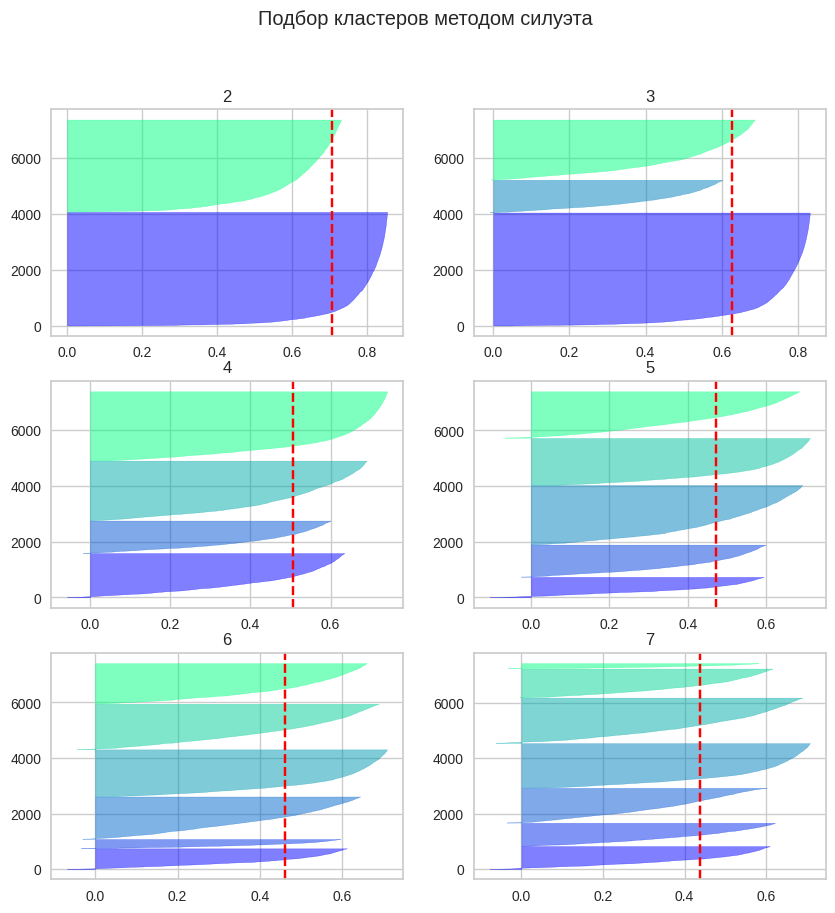

In [25]:
clasters = range(2, 8)
fig, ax = plt.subplots(3, 2)
plt.suptitle("Подбор кластеров методом силуэта")
for i in clasters:
    model = KMeans(n_clusters=i, random_state=123)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(model, colors='winter', ax=ax[q-1][mod])
    ax[q-1][mod].set_title(i)
    visualizer.fit(df_pca)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

3.2. Выберите оптимальное количество кластеров и объясните свой выбор.

Оптимальное число кластеров - 4, так как в данном случае их толщина и размер схожи.

3.3. Повторите визуализацию данных по первым двум главным компонентам, размечая наблюдения каждого кластера своим цветом.

In [26]:
# по методу PCA
model = KMeans(n_clusters=4, random_state=123)
labels_pca = model.fit_predict(df_pca)

fig = px.scatter(
    x=df_pca[:, 0],
    y=df_pca[:, 1],
    color=labels_pca,
    color_continuous_scale="tealgrn",
    title="Кластеры по первым двум главным компонентам РСА",
)
fig.show()

/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



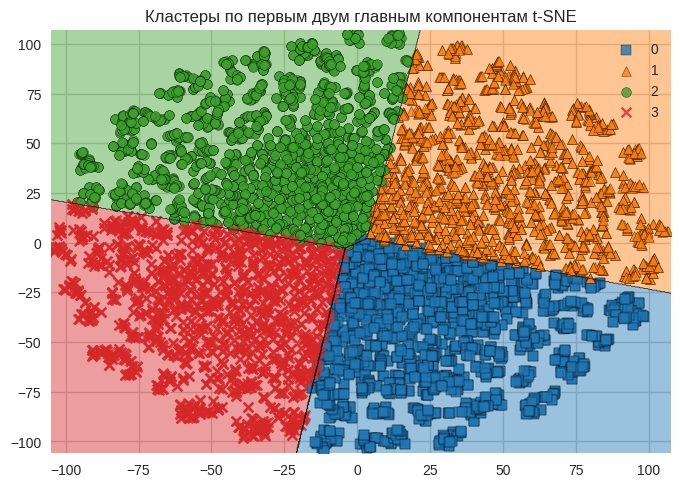

In [27]:
# по методу t-SNE
labels_tsne = model.fit_predict(df_tsne)
ax = plot_decision_regions(df_tsne, labels_tsne, model,hide_spines=True)
ax.set_title('Кластеры по первым двум главным компонентам t-SNE')
plt.show()

#### 4. Оцените качество кластеризации:

4.1. Подгрузите реальные метки наблюдений из файла y_train.txt, а также их значения из файла activity_labels.txt.

In [28]:
try:
    y_train = np.loadtxt(
        "/home/olgatorres/PycharmProjects/ArchitectorAI/UCI HAR Dataset/y_train.txt"
    )
    with open(
        "/home/olgatorres/PycharmProjects/ArchitectorAI/UCI HAR Dataset/activity_labels.txt",
        "r",
    ) as f:
        lines = f.readlines()
    activities = {int(line.split()[0]):line.split()[1].rstrip() for line in lines}

except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

4.2. Определите, насколько логична полученная кластеризация. Можно, например, сформировать сводную таблицу, где в строках будут реальные активности, а в столбцах — лейблы, полученные согласно кластеризации.

In [29]:
print(activities)
real_labels = [activities.get(i) for i in y_train]

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [30]:
clasters = pd.DataFrame({'claster_real': real_labels, 'claster':labels_pca})
clasters.sample(5)

,claster_real,claster
1028,SITTING,3
6050,WALKING_UPSTAIRS,2
837,WALKING_UPSTAIRS,2
2465,LAYING,0
4089,LAYING,3


In [31]:
clasters.groupby(["claster_real", "claster"])["claster"].agg("count").to_frame(
    name="count"
).T

claster_real LAYING          SITTING         STANDING      WALKING       \
claster           0   2    3       0  2    3        0    3       1    2   
count           465  11  931     473  1  812      642  732     396  830   

claster_real WALKING_DOWNSTAIRS      WALKING_UPSTAIRS            
claster                       1    2                0    1    2  
count                       632  354                3  127  943

4.3. Сделайте выводы, опишите, почему те или иные виды активности могли объединиться в один кластер, а другие отделиться от них.

*Вывод:*\
6 кластеров по методу силуэта настолько были неравномеры, что видимо, надо использовать еще какой-то способ для подбора кластеров.\
Виды активности с ходьбой распределились между 1 и 2 кластером, им не хватило еще 1 кластера для разеделения.
Остальные три вида (спокойные) распределились между 0 и 3 кластером (по несколько значений попали во 2 кластер),\
то есть им тоже не хватило 1 кластера.

Попробуем на 6 кластерах и на 55 признаках (90% дисперсии)

In [32]:
n_components = 55
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_norm)

model = KMeans(n_clusters=6, random_state=123)
labels_pca = model.fit_predict(df_pca)

In [33]:
clasters = pd.DataFrame({'claster_real': real_labels, 'claster':labels_pca})
clasters = clasters.groupby(["claster_real", "claster"])["claster"].agg("count").to_frame(
    name="count"
).T
clasters

claster_real LAYING               SITTING             STANDING      WALKING  \
claster           0     2   3   4       0   2  3    4        0    4       1   
count           277  1099  11  20     371  79  1  835      462  912     568   

claster_real          WALKING_DOWNSTAIRS           WALKING_UPSTAIRS            \
claster         3   5                  1    3    5                0    1    3   
count         569  89                620  179  187                2  182  870   

claster_real      
claster        5  
count         19

In [34]:
clasters = clasters.T.reset_index()
fig = make_subplots(
    rows=3,
    cols=2,
    specs=[
        [{"type": "pie"}, {"type": "pie"}],
        [{"type": "pie"}, {"type": "pie"}],
        [{"type": "pie"}, {"type": "pie"}],
    ],
    subplot_titles=sorted(list(activities.values())),
)
row, col = 1, 1
for activity in sorted(activities.values(), reverse=True):
    grouped = clasters.loc[clasters.claster_real == activity][["count", "claster"]]
    fig.add_trace(
        go.Pie(
            values=grouped["count"],
        ),
        row=row,
        col=col,
    )
    col += 1
    if col == 3:
        row += 1
        col = 1
fig.update_layout(autosize=False, width=700, height=1000, showlegend=False)
fig.show()

Итак, с 55 признаками и 6 кластерами результат следующий:
- WALKING - 1 и 3 кластер;
- WALKING_UPSTAIRS - 3;
- WALKING_DOWNSTAIRS -1;
- SITTING - 4;
- STANDING - 0 и 4;
- LAYING - 2.\
На реализацию с помощью TSNE на таком кол-ве компонент не хватает мощности (method='exact').\
То есть увеличение кол-ва признаков, не значит улучшение результата.